In [1]:
# %pip install prophet pandas numpy scikit-learn tensorflow matplotlib

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

# Load and concatenate data
dfs = []
for i in range(1, 7):
    df = pd.read_csv(f'./data/APBN/Tabel Anggaran Belanja Pemerintah Pusat Berdasarkan Fungsi, {2005 + (i-1)*3}-{2007 + (i-1)*3}.csv')
    penerimaan_pajak = df[df.iloc[:, 0].str.strip() == 'Jumlah'].iloc[:, 1:4]
    cleaned_df = pd.DataFrame({
        'Tahun': [str(year) for year in range(2007 + (i-1)*3, 2010 + (i-1)*3)],
        'APBN': [str(value) for value in penerimaan_pajak.values.flatten()]
    })
    dfs.append(cleaned_df)
    
print(dfs)

2024-12-17 03:15:59.024234: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734380159.042548    4576 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734380159.047830    4576 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 03:15:59.067653: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/litfan/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and

[  Tahun      APBN
0  2007    266220
1  2008  427598.0
2  2009  504776.0,   Tahun      APBN
0  2010    573431
1  2011  716376.0
2  2012  725243.0,   Tahun       APBN
0  2013     836578
1  2014   964997.0
2  2015  1154381.0,   Tahun       APBN
0  2016    1249943
1  2017  1392442.0
2  2018  1325551.0,   Tahun       APBN
0  2019    1315526
1  2020  1454494.0
2  2021  1634340.0,   Tahun       APBN
0  2022  1683477.2
1  2023  1954548.5
2  2024  1944542.3]


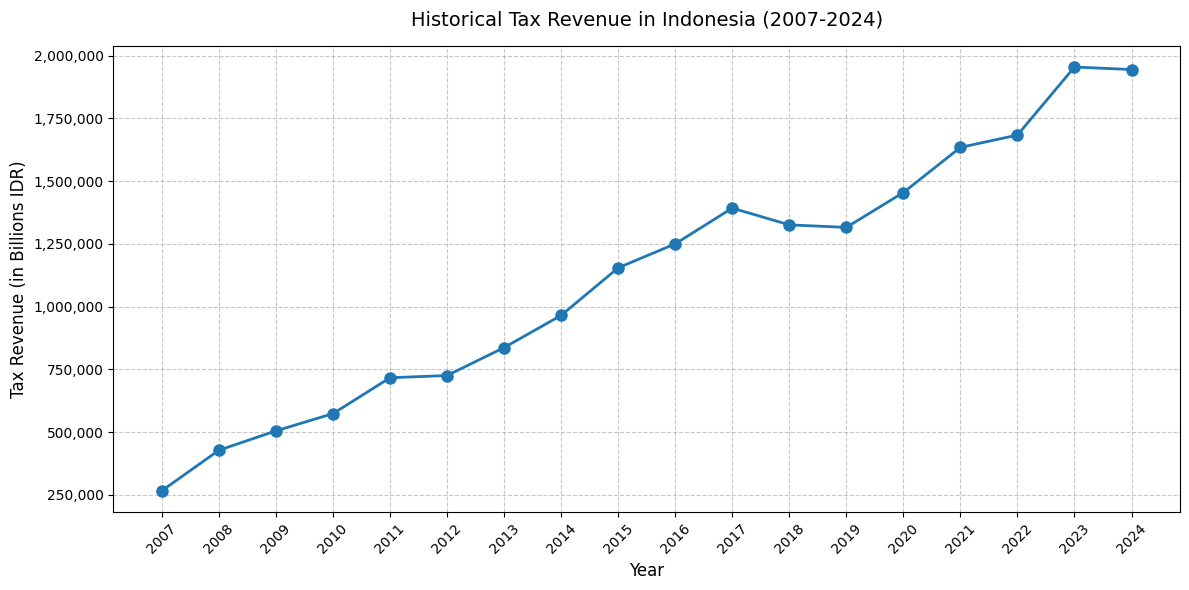

I0000 00:00:1734380163.004143    4576 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2172 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1734380165.135915    5745 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


03:16:07 - cmdstanpy - INFO - Chain [1] start processing
03:16:07 - cmdstanpy - INFO - Chain [1] done processing


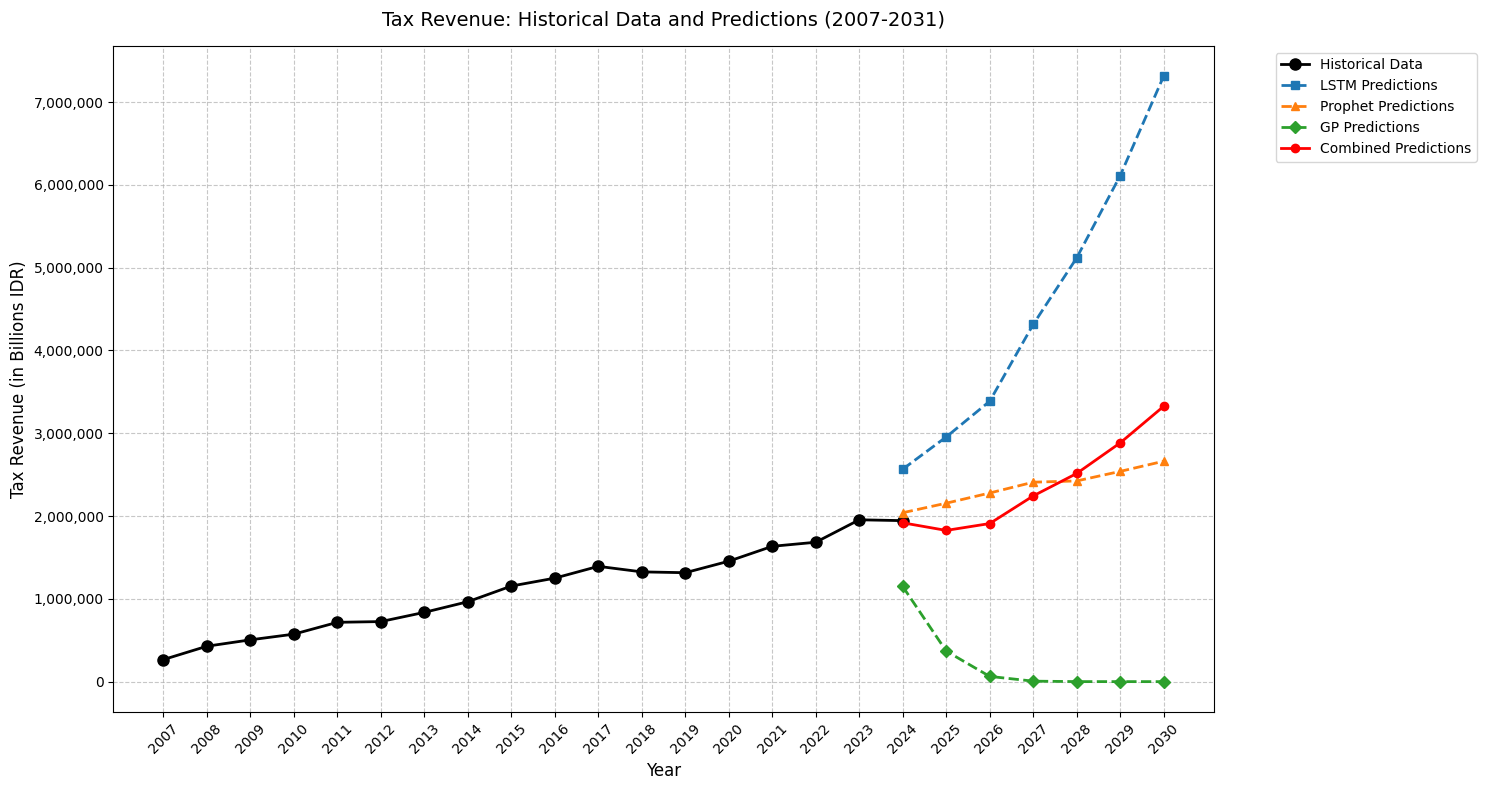


Predictions for 2024-2031:

Year		LSTM		Prophet		GP		Combined
--------------------------------------------------------------------------------
2024		2565942.75		2039864.91		1149017.40		1918275.02
2025		2955055.75		2155143.90		368696.21		1826298.62
2026		3386898.25		2278151.87		62969.98		1909340.03
2027		4314153.00		2408833.81		5638.53		2242875.11
2028		5118105.00		2423906.94		261.40		2514091.11
2029		6111092.50		2539185.94		6.22		2883428.22
2030		7313568.00		2662193.91		0.08		3325254.00


In [2]:
data = pd.concat(dfs).reset_index(drop=True)
data['APBN'] = pd.to_numeric(data['APBN'], errors='coerce').fillna(0)

# Plot historical data
plt.figure(figsize=(12, 6))
plt.plot(data['Tahun'], data['APBN'], marker='o', linewidth=2, markersize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Historical Tax Revenue in Indonesia (2007-2024)', fontsize=14, pad=15)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Tax Revenue (in Billions IDR)', fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# LSTM Implementation
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data['APBN'].values.reshape(-1, 1))

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 3
dataset = data_scaled
train_size = int(len(dataset) * 0.67)
train, test = dataset[0:train_size], dataset[train_size:]

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# Enhanced LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Increased epochs
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=0)

# Adjust the predictions to extend until 2031 (7 years from 2024)
future_years = [str(year) for year in range(2024, 2032)]

# LSTM Implementation
# Modified to predict 7 years ahead
lstm_future = []
last_sequence = data_scaled[-look_back:]
last_sequence = np.reshape(last_sequence, (1, look_back, 1))

for _ in range(7):  # Changed from 5 to 7 years
    next_pred = model.predict(last_sequence)
    lstm_future.append(next_pred[0,0])
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[0,-1,0] = next_pred

lstm_future = np.array(lstm_future).reshape(-1, 1)
lstm_future = scaler.inverse_transform(lstm_future)


# Prophet Implementation
prophet_data = pd.DataFrame({
    'ds': pd.to_datetime(data['Tahun']),
    'y': data['APBN']
})

prophet_model = Prophet(yearly_seasonality=True)
prophet_model.fit(prophet_data)

# Extend Prophet predictions to 2031
future_dates = prophet_model.make_future_dataframe(periods=7, freq='Y')  # Changed from 5 to 7 years
prophet_forecast = prophet_model.predict(future_dates)

# Gaussian Process Implementation
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(1, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Fit the GP model
X_train = np.arange(len(data)).reshape(-1, 1)
y_train = data['APBN'].values
gp.fit(X_train, y_train)

# Extend GP predictions to 2031
X_pred = np.arange(len(data), len(data) + 7).reshape(-1, 1)  # Changed from 5 to 7 years
y_pred, sigma = gp.predict(X_pred, return_std=True)
X_pred = np.arange(len(data), len(data) + 7).reshape(-1, 1)  # Changed from 5 to 7 years
y_pred, sigma = gp.predict(X_pred, return_std=True)

# Plot predictions
plt.figure(figsize=(15, 8))

# Plot historical data
plt.plot(data['Tahun'], data['APBN'], marker='o', label='Historical Data', linewidth=2, color='black', markersize=8)

# Plot predictions
future_years = [str(year) for year in range(2024, 2031)]  # Updated range

# LSTM predictions
plt.plot(future_years, lstm_future, marker='s', label='LSTM Predictions', linestyle='--', linewidth=2)

# Prophet predictions
prophet_predictions = prophet_forecast['yhat'][-7:].values  # Changed from 5 to 7 years
plt.plot(future_years, prophet_predictions, marker='^', label='Prophet Predictions', linestyle='--', linewidth=2)

# Gaussian Process predictions
plt.plot(future_years, y_pred, marker='D', label='GP Predictions', linestyle='--', linewidth=2)

# Calculate combined predictions
combined_predictions = (lstm_future.flatten() + prophet_predictions + y_pred) / 3
plt.plot(future_years, combined_predictions, marker='o', label='Combined Predictions', linestyle='-', linewidth=2, color='red')

# Formatting
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Tax Revenue: Historical Data and Predictions (2007-2031)', fontsize=14, pad=15)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Tax Revenue (in Billions IDR)', fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print the predictions
print("\nPredictions for 2024-2031:")
print("\nYear\t\tLSTM\t\tProphet\t\tGP\t\tCombined")
print("-" * 80)
for i, year in enumerate(future_years):
    print(f"{year}\t\t{lstm_future[i][0]:.2f}\t\t{prophet_predictions[i]:.2f}\t\t{y_pred[i]:.2f}\t\t{combined_predictions[i]:.2f}")